## CUNY DATA698
### Topic Modeling for Forensics Analysis of Text-Based Conversations
#### Michael Ippolito
#### May 2024

This is part of a series of Python Jupyter notebooks in support of my master's capstone project. The aim of the project is to study various methods of preprocessing, topic modeling, and postprocessing text-based conversation data often extracted from electronic devices recovered during criminal or cybersecurity investigations.

The Jupyter notebooks used in this project are as follows:

| Module | Purpose |
|--------|---------|
| eda1.ipynb | Exploratory data analysis of the four datasets used in the study. |
| modeling1.ipynb | Loads and preprocesses the datasets, performs various topic models, postprocesses the topic representations. |
| survey1.ipynb | Generates conversation text and topic representations to submit to Mechanical Turk. It later parses the results and incorporates them into my own hand-labeled results. |
| survey2.ipynb | Loads Mechanical Turk survey results and evaluates them for quality based on reading speed and attention questinos. |
| eval1.ipynb | Evaluates the topic modeling and survey results based on topic coherence, semantic quality, and topic relevance. |

The study uses the following four datasets:

1. Chitchat
2. Topical Chat
3. Ubuntu Dialogue
4. Enron Email

For further details and attribution, see my paper in this github repo.


### Exploratory Data Analysis
#### eda1.ipynb

The code in this module performs exploratory data analysis (EDA) on the four datasets. First, it loads and tokenizes the datasets, then it generates some frequency distribution diagrams based on the top-N words. Then it reduces the dimensionality of the data down to two dimensions and generates t-distributed stochastic neighbor embedding (t-SNE) graphs to visually identify clusters of similar words.


### Initialization

This section:

1. Loads required libraries
2. Loads the spacy model used for tokenising
3. Instantiates the chitchat dataset
4. Defines a custom stopword list
5. Sets global parameters used throughout the module
6. Loads pretrained word embeddings used for t-SNE analysis
7. Defines a tokenising function
8. Initialises a dataframe to hold various statistics about the datasets


In [118]:
# Load libraries
import os
import re
import json
import numpy as np
import pandas as pd
import chitchat_dataset as ccc
import spacy
from collections import Counter
import chitchat_dataset as ccc
from textacy.extract import kwic
import random
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from gensim.models import word2vec
from matplotlib import pyplot as plt


In [130]:
# Load spacy model (for tokenizing)
spacy_model = 'en_core_web_md'
print(f'loading spacy model {spacy_model}')
nlp = spacy.load(spacy_model)
nlp.add_pipe('sentencizer')

# Load spacy model - tokeniser only
print(f'loading spacy model {spacy_model} - tokeniser only')
nlp_tokens = spacy.load(spacy_model)
print('\tall pipes:', [pipe for pipe in nlp_tokens.pipe_names])
all_but_tagger = [pipe for pipe in nlp_tokens.pipe_names if pipe not in ['tagger', 'lemmatizer', 'tok2vec', 'attribute_ruler', 'morphologizer']]
print('\tdisabling:', all_but_tagger)
nlp_tokens.disable_pipes(*all_but_tagger)
#nlp_tokens.add_pipe('parser')
nlp_tokens.add_pipe('sentencizer')
nlp_tokens.max_length = 13000000  # Increase the max length

# Instantiate chitchat dataset
ccds = ccc.Dataset()

# Custom stopwords (based on enron emails)
custom_stop = ['message', 'subject', 'version', 'to', 'encoding', 'content', 'ect@ect', 'date', 'time', 'type', 'bcc', 'cc', 'text', 'transfer', 'charset', 'mime',
                'folder', 'origin', '-0800', '-0700', 'pdt', 'pst', 'mail', 'enron', 'filename', 'corp', 'ascii', 'enron@enron', 
                'folders\\all', 'forwarded', 'folders\\\'sent', 'ees@ees', 'email', 'mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun', 'ect', 'hou']

# Dataset list
dslist = ['cc', 'tc', 'ud', 'ee']
datasetmap = {'cc': 'chitchat', 'tc': 'topical chat', 'ud': 'ubuntu dialogue', 'ee': 'enron email'}
rev_datasetmap = {'chitchat': 'cc', 'topical chat': 'tc', 'ubuntu dialogue': 'ud', 'enron email': 'ee'}


loading spacy model en_core_web_md
loading spacy model en_core_web_md - tokeniser only
	all pipes: ['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']
	disabling: ['parser', 'ner']


In [49]:
# Load pretrained word2vec embeddings (used for t-SNE analysis)
print(f'loading pretrained word2vec embeddings from {embeddir}{embedmodel_word2vec}')
ptmodel_word2vec = KeyedVectors.load_word2vec_format(embeddir + embedmodel_word2vec, binary=True)
print(f'\tsize of pretrained model: {len(ptmodel_word2vec)} tokens with {ptmodel_word2vec.vector_size} vectors')


loading pretrained word2vec embeddings from C:/Users/micha/Documents/698/embeddings/google-news/GoogleNews-vectors-negative300.bin
	size of pretrained model: 3000000 tokens with 300 vectors


In [8]:
# Function to tokenise with spacy
def do_tokenise(txt, topn, pos_list=None):
    """
    Purpose:          Tokenises text using Spacy.
    Parameters:
        txt           String-type text to be tokenised.
        topn          The number of most frequent words to return.
        post_list     List of Spacy-formated parts of speech tags.
    Returns:
        ct_words      The word count.
        ct_sents      The number of sentences in the text.
        topn_words    The top-n most frequent words.
        words         The tokens tokenised from the text (in Spacy format).
    """

    # Tokenise
    tokens = nlp_tokens(txt)
    if not pos_list is None:
        words = [token.text for token in tokens if not token.is_stop and not token.is_punct and not token.text == ' ' and len(token.text) > 2 and token.pos_ in pos_list and \
                token.text.lower() not in custom_stop]
    else:
        words = [token.text for token in tokens if not token.is_stop and not token.is_punct and not token.text == ' ' and len(token.text) > 2]
    ct_words = len(tokens)
    word_freq = Counter(words)
    topn_words = word_freq.most_common(topn)
    
    # Sentencise
    sents = tokens.sents
    ct_sents = len(Counter(sents))

    return ct_words, ct_sents, topn_words, words

# Test suite
ct_words, ct_sents, topn_words, tokens = do_tokenise("This is a sentence. Hello, Jim. This is another sentence.", 5, ['NOUN', 'PROPN', 'VERB'])
print(ct_words, ct_sents, topn_words, tokens)


14 3 [('sentence', 2), ('Jim', 1)] ['sentence', 'Jim', 'sentence']


In [9]:
# Instantiate dataframe to hold various stats about the datasets
dfstats = pd.DataFrame(columns=['Dataset', 'Conversations', 'Exchanges', 'Avg Exchanges Per Conv', 
                                'Sentences', 'Avg Sentences Per Conv', 'Words', 'Avg Words Per Conv', 'Top Words'])


### Chitchat dataset

This section loads, tokenises, and collects basic stats about the Chitchat dataset.


In [19]:
#############################################
# Chitchat dataset
#############################################

# Function to load the Chitchat dataset
def load_chitchat(num_docs):
    """
    Purpose:             To load the Chitchat dataset into memory.
    Parameters:
        num_docs         The number of conversations to load.
    Returns:
        docs_txt         List of conversations in plain-text format.
        ct_msgs_corpus   Count of messages (conversations) in the corpus.
        ct_chats_corpus  Count of chats within the corpus (each message can contain multiple chats).
    """

    # Init document list
    docs_txt = []
    
    # Iterate through items in dataset
    ct = 0
    ct_msgs_corpus = []
    ct_chats_corpus = []
    for convo_id, convo in ccds.items():
    
        # Conversation header info
        #print(convo_id, convo['ratings'], convo['start'], convo['prompt'], '\n')
        ct += 1
    
        # Init 
        doc_msgs = ''
        
        # Iterate through messages; each message is from a single person and contain multiple chats
        ct_msgs = 0
        ct_chats = []
        for msg in convo['messages']:
    
            # Concatenate all chats within this message
            msg_chats = [chat['text'] for chat in msg]
            ct_chat = len(msg_chats)
            ct_chats.append(ct_chat)
            msg_chats = ' '.join(msg_chats)            
            doc_msgs += msg_chats + ' '
            ct_msgs += 1

        # Append count to the overall corpus counts (for stats purposes)
        #print(ct_msgs)
        #print(ct_chats)
        ct_msgs_corpus.append(ct_msgs)
        ct_chats_corpus.append(ct_chats)
    
        # Append to docs list
        docs_txt.append(doc_msgs)
    
        # Show first few docs
        """
        if ct < 6:
            print(ct)
            print(doc_msgs)
            print()
        """
    
        # Break early
        if num_docs > 0 and ct >= num_docs: break
    
    # Doc summary
    print(f'Number of docs (conversations): {len(docs_txt)}')

    # Return
    return docs_txt, ct_msgs_corpus, ct_chats_corpus


In [45]:
# Load chitchat dataset
cc_txt, cc_msg_ct, cc_chat_ct = load_chitchat(0)
print(cc_txt[0])
print(cc_msg_ct[0])
print(cc_chat_ct[0])


Number of docs (conversations): 7168
Hello How are you doing today? whats up MD im doing good how are you doing? Im alright, I just took a nap. But it was one of those naps that doesnt help anything. It just makes everything worse and you question all your life choices oh wow haha so you still feel tired huh? Yeah did you go to bed late? I have more of a head ache than anything else dude thats terrible No, Its just adjusting to a time change But enough about me What are you up to? im refining my skills on Sketch App have you heard of Sketch? I havent What is it? you know what adobe illustrator is right? Yes its a vector graphic editor like illustrator but its a lot more light weight and its for UX designers to design UI Oh nice! What have you been practicing designing Ive been trying to learn more tools on sketch and just get faster at it] Im doing a free lance job for a professor for his app idea and he needs a mockup of what the app will look like for his pitch Wow that is cool! When

In [46]:
# Make dataframe
dfcc = pd.DataFrame({'txt': cc_txt, 'msg_ct': cc_msg_ct, 'chat_ct': cc_chat_ct})
print(dfcc.shape)

# Only take conversations with more than 5 exchanges
dfcc = dfcc[dfcc['msg_ct'] > 5].reset_index()
print(dfcc.shape)
#display(dfcc)


(7168, 3)
(2963, 4)


In [47]:
# Iterate to tokenise
ct_words_corpus = []
ct_sents_corpus = []
topn_words_corpus = []
words_corpus_cc = []
topn = 20
for i, row in dfcc.iterrows():
    if i % 100 == 0: print(i)
    ct_words, ct_sents, topn_words, words = do_tokenise(row['txt'], topn, ['NOUN', 'PROPN', 'VERB'])
    ct_words_corpus.append(ct_words)
    ct_sents_corpus.append(ct_sents)
    topn_words_corpus.append(topn_words)
    words_corpus_cc.append(words)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900


In [52]:
# Show dataframe
dftmp = pd.DataFrame({'ct_words': ct_words_corpus, 'ct_sents': ct_sents_corpus, 'topn_words': topn_words_corpus, 'words': words_corpus_cc})
display(dftmp)
dfcc2 = pd.concat([dfcc, dftmp], axis=1, ignore_index=False)
display(dfcc2)


,ct_words,ct_sents,topn_words,words
0,566,28,"[(think, 5), (know, 3), (deadline, 3), (pictur...","[today, good, took, nap, naps, help, makes, qu..."
1,683,26,"[(like, 10), (soccer, 7), (play, 5), (think, 5...","[student, nigeria, freshman, feel, got, accept..."
2,404,19,"[(people, 4), (seen, 3), (talking, 3), (think,...","[gon, close, window, sounds, think, lot, peopl..."
3,419,14,"[(think, 7), (falafel, 6), (shoe, 6), (need, 5...","[know, falafel, fact, know, spelled, think, th..."
4,3475,161,"[(think, 21), (lot, 14), (writing, 14), (peopl...","[Helllo, think, program, meet, bit, stopped, s..."
...,...,...,...,...
2958,839,69,"[(going, 9), (cherry, 9), (coconut, 7), (choco...","[Adam, going, baby, chick, poop, Hahaha, going..."
2959,390,16,"[(got, 3), (love, 3), (climbing, 3), (need, 3)...","[man, Adam, going, having, day, got, slept, fe..."
2960,466,44,"[(country, 6), (debt, 6), (people, 3), (conseq...","[power, like, balance, budget, spend, money, t..."
2961,99,8,"[(choice, 2), (got, 2), (working, 2), (Kanye, ...","[Kanye, dad, choice, choice, dude, major, got,..."


,index,txt,msg_ct,chat_ct,ct_words,ct_sents,topn_words,words
0,0,Hello How are you doing today? whats up MD im ...,35,"[2, 3, 1, 2, 1, 1, 1, 1, 3, 2, 2, 1, 1, 1, 2, ...",566,28,"[(think, 5), (know, 3), (deadline, 3), (pictur...","[today, good, took, nap, naps, help, makes, qu..."
1,1,hi anyone here hey whats up yeah how are you i...,57,"[2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, ...",683,26,"[(like, 10), (soccer, 7), (play, 5), (think, 5...","[student, nigeria, freshman, feel, got, accept..."
2,11,Hey! Hey I'm gonna close the other window if t...,18,"[1, 1, 1, 1, 1, 1, 2, 1, 1, 3, 3, 3, 1, 1, 2, ...",404,19,"[(people, 4), (seen, 3), (talking, 3), (think,...","[gon, close, window, sounds, think, lot, peopl..."
3,14,I don't know what falafel is In fact I don't e...,25,"[7, 2, 1, 1, 1, 2, 1, 1, 1, 2, 3, 1, 1, 2, 4, ...",419,14,"[(think, 7), (falafel, 6), (shoe, 6), (need, 5...","[know, falafel, fact, know, spelled, think, th..."
4,20,Helllo!!! Hello! I think this program is bugg...,140,"[1, 1, 3, 1, 2, 2, 1, 1, 2, 3, 3, 3, 2, 3, 1, ...",3475,161,"[(think, 21), (lot, 14), (writing, 14), (peopl...","[Helllo, think, program, meet, bit, stopped, s..."
...,...,...,...,...,...,...,...,...
2958,7152,Hello? Hey Adam! How's it going? Did the baby ...,48,"[1, 2, 2, 1, 1, 2, 2, 2, 4, 2, 1, 1, 1, 1, 3, ...",839,69,"[(going, 9), (cherry, 9), (coconut, 7), (choco...","[Adam, going, baby, chick, poop, Hahaha, going..."
2959,7154,Hi how are you hey doing great man how are you...,27,"[1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, ...",390,16,"[(got, 3), (love, 3), (climbing, 3), (need, 3)...","[man, Adam, going, having, day, got, slept, fe..."
2960,7157,"If I were in power, I'd like to balance the bu...",29,"[2, 2, 2, 1, 1, 3, 1, 1, 1, 1, 1, 1, 2, 1, 1, ...",466,44,"[(country, 6), (debt, 6), (people, 3), (conseq...","[power, like, balance, budget, spend, money, t..."
2961,7159,Hello hey! Kanye idk my dad? good choice thoug...,12,"[1, 1, 1, 2, 1, 2, 2, 2, 2, 3, 2, 2]",99,8,"[(choice, 2), (got, 2), (working, 2), (Kanye, ...","[Kanye, dad, choice, choice, dude, major, got,..."


conversations: 2963
exchanges: 132554
avg exchanges per conversation: 44.73641579480257
sentences: 151156
avg sentences per conversation: 51.01451231859602
words: 2610900
avg words per conversation: 881.1677354033075
topn words: [('think', 11277), ('know', 8847), ('people', 6814), ('like', 6102), ('going', 5168), ('lot', 4800), ('want', 4729), ('love', 4449), ('got', 4355), ('Haha', 3694), ('things', 3663), ('school', 3077), ('thing', 3017), ('work', 2977), ('way', 2954), ('day', 2930), ('need', 2759), ('feel', 2748), ('class', 2507), ('stuff', 2433)]



,Dataset,Conversations,Exchanges,Avg Exchanges Per Conv,Sentences,Avg Sentences Per Conv,Words,Avg Words Per Conv,Top Words
0,Chitchat,2963,132554,44.736416,151156,51.014512,2610900,881.167735,"think, know, people, like, going, lot, want, l..."


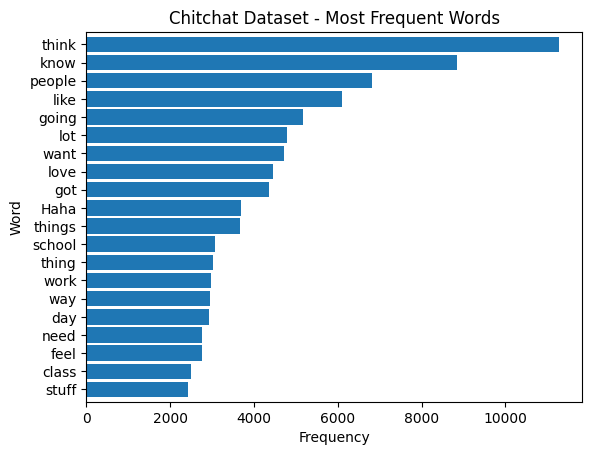

In [94]:
# Overall stats
ct_conv = dfcc2.shape[0]
ct_exch = dfcc2['msg_ct'].sum()
ct_sents = dfcc2['ct_sents'].sum()
ct_words = dfcc2['ct_words'].sum()
print('conversations:', ct_conv)
print('exchanges:', ct_exch)
print('avg exchanges per conversation:', ct_exch / ct_conv)
print('sentences:', ct_sents)
print('avg sentences per conversation:',  ct_sents/ ct_conv)
print('words:', ct_words)
print('avg words per conversation:', ct_words / ct_conv)

all_words = []
for doc in [words for words in dfcc2['words'].values]:
    for words in doc:
        all_words.append(words)
word_freq = Counter(all_words)
topn_words_cc = word_freq.most_common(topn)

print('topn words:', topn_words_cc)
print()

# Freq dist
dff = pd.DataFrame(topn_words_cc)
dff.columns = ['word', 'freq']
dff.index=dff['word']
#display(dff)
ax = dff.plot(kind='barh', width=0.85, legend=False)
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Word', title='Chitchat Dataset - Most Frequent Words')

# Stats
topstr = ', '.join([w[0] for w in topn_words_cc])
dfstats = pd.DataFrame({
    'Dataset': 'Chitchat',
    'Conversations': [ct_conv],
    'Exchanges': [ct_exch],
    'Avg Exchanges Per Conv': [ct_exch / ct_conv], 
    'Sentences': [ct_sents],
    'Avg Sentences Per Conv': [ct_sents/ ct_conv],
    'Words': [ct_words],
    'Avg Words Per Conv': [ct_words / ct_conv],
    'Top Words': [topstr]
})
#dfstats = pd.concat([dfstats, dftmp], ignore_index=True, axis=0)
display(dfstats)


### Topical Chat dataset

This section loads, tokenises, and collects basic stats about the Topical Chat dataset.


In [25]:
#############################################
# Topical Chat dataset
#############################################

# Function to load the Topical Chat dataset
def load_topical(num_docs):
    """
    Purpose:             To load the Topical Chat dataset into memory.
    Parameters:
        num_docs         The number of conversations to load.
    Returns:
        docs_txt         List of conversations in plain-text format.
        ct_msgs_corpus   Count of messages (conversations) in the corpus.
    """

    # Path
    path_to_docs = 'C:/Users/micha/Documents/698/corpora/topical_chat/train.json'
    
    # Init document list
    docs_txt = []

    # Load file
    with open(path_to_docs, 'r', encoding='latin-1') as fh:

        j = json.load(fh)

    # Iterate through items in dataset
    ct = 0
    ct_msgs_corpus = []
    ct_chats_corpus = []
    for k in j.keys():

        ct += 1

        # Get conversation
        conv = j[k]['content']

        # Init 
        doc_msgs = ''
        
        # Iterate over each message in the conversation; each message is by one person and can contain multiple sentences
        ct_msgs = 0
        for msg in conv:

            # Concatenate all chats within this message
            msg_txt = msg['message']
            doc_msgs += msg_txt + ' '
            ct_msgs += 1

        # Append count to the overall corpus counts (for stats purposes)
        ct_msgs_corpus.append(ct_msgs)
    
        # Append to docs list
        docs_txt.append(doc_msgs)
    
        # Break early
        if num_docs > 0 and ct >= num_docs: break
    
    # Doc summary
    print(f'Number of docs (conversations): {len(docs_txt)}')

    # Return
    return docs_txt, ct_msgs_corpus


In [54]:
# Load topical chat dataset
tc_txt, tc_msg_ct = load_topical(3000)
#print(tc_msg_ct)


Number of docs (conversations): 3000


In [55]:
# Make dataframe
dftc = pd.DataFrame({'txt': tc_txt, 'msg_ct': tc_msg_ct, 'chat_ct': 1})
print(dftc.shape)

# Only take conversations with more than 5 exchanges
dftc = dftc[dftc['msg_ct'] > 5].reset_index()
print(dftc.shape)
#display(dftc)


(3000, 3)
(3000, 4)


In [56]:
# Iterate to tokenise
ct_words_corpus = []
ct_sents_corpus = []
topn_words_corpus = []
words_corpus_tc = []
topn = 20
for i, row in dftc.iterrows():
    if i % 100 == 0: print(i)
    ct_words, ct_sents, topn_words, words = do_tokenise(row['txt'], topn, ['NOUN', 'PROPN', 'VERB'])
    ct_words_corpus.append(ct_words)
    ct_sents_corpus.append(ct_sents)
    topn_words_corpus.append(topn_words)
    words_corpus_tc.append(words)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900


In [57]:
# Show dataframe
dftmp = pd.DataFrame({'ct_words': ct_words_corpus, 'ct_sents': ct_sents_corpus, 'topn_words': topn_words_corpus, 'words': words_corpus_tc})
display(dftmp)
dftc2 = pd.concat([dftc, dftmp], axis=1, ignore_index=False)
display(dftc2)


,ct_words,ct_sents,topn_words,words
0,429,38,"[(Google, 10), (fish, 5), (fan, 4), (lot, 3), ...","[fan, Google, Microsoft, technology, ways, sec..."
1,236,16,"[(know, 5), (cha, 4), (dancer, 3), (like, 2), ...","[like, dance, know, Bruce, Lee, cha, cha, danc..."
2,443,39,"[(fish, 8), (guess, 5), (know, 4), (cat, 4), (...","[use, Google, love, company, hear, founded, th..."
3,401,43,"[(dance, 6), (dancer, 5), (know, 4), (shoes, 4...","[like, dance, love, dance, lot, Dancing, lot, ..."
4,261,21,"[(know, 6), (lot, 3), (love, 2), (dancer, 2), ...","[like, dance, love, know, Bruce, Lee, dancer, ..."
...,...,...,...,...
2995,269,23,"[(know, 5), (fiction, 4), (like, 3), (travel, ...","[like, fiction, know, wiki, page, list, charac..."
2996,409,42,"[(reading, 6), (read, 4), (lol, 4), (know, 4),...","[like, read, love, reading, compete, world, re..."
2997,571,36,"[(reading, 7), (people, 6), (world, 4), (books...","[know, takes, mass, system, Gigantic, perceive..."
2998,552,47,"[(soccer, 6), (reading, 4), (think, 4), (like,...","[Greetings, hope, readings, like, read, readin..."


,index,txt,msg_ct,chat_ct,ct_words,ct_sents,topn_words,words
0,0,Are you a fan of Google or Microsoft? Both are...,21,1,429,38,"[(Google, 10), (fish, 5), (fan, 4), (lot, 3), ...","[fan, Google, Microsoft, technology, ways, sec..."
1,1,do you like dance? Yes I do. Did you know Bru...,21,1,236,16,"[(know, 5), (cha, 4), (dancer, 3), (like, 2), ...","[like, dance, know, Bruce, Lee, cha, cha, danc..."
2,2,Hey what's up do use Google very often?I reall...,21,1,443,39,"[(fish, 8), (guess, 5), (know, 4), (cat, 4), (...","[use, Google, love, company, hear, founded, th..."
3,3,Hi! do you like to dance? I love to dance a l...,23,1,401,43,"[(dance, 6), (dancer, 5), (know, 4), (shoes, 4...","[like, dance, love, dance, lot, Dancing, lot, ..."
4,4,do you like dance? I love it. Did you know Bru...,21,1,261,21,"[(know, 6), (lot, 3), (love, 2), (dancer, 2), ...","[like, dance, love, know, Bruce, Lee, dancer, ..."
...,...,...,...,...,...,...,...,...
2995,2995,do you like fiction? I sure do. Did you know t...,21,1,269,23,"[(know, 5), (fiction, 4), (like, 3), (travel, ...","[like, fiction, know, wiki, page, list, charac..."
2996,2996,Hello! Do you like to read? I love reading! Yo...,21,1,409,42,"[(reading, 6), (read, 4), (lol, 4), (know, 4),...","[like, read, love, reading, compete, world, re..."
2997,2997,Did you know that the sun takes up 99.86% of t...,22,1,571,36,"[(reading, 7), (people, 6), (world, 4), (books...","[know, takes, mass, system, Gigantic, perceive..."
2998,2998,Greetings! I hope you are well. These readings...,22,1,552,47,"[(soccer, 6), (reading, 4), (think, 4), (like,...","[Greetings, hope, readings, like, read, readin..."


conversations: 3000
exchanges: 65563
avg exchanges per conversation: 21.854333333333333
sentences: 118536
avg sentences per conversation: 39.512
words: 1511902
avg words per conversation: 503.96733333333333
topn words: [('know', 10751), ('think', 6536), ('like', 4777), ('wonder', 3154), ('lot', 3041), ('people', 2836), ('guess', 2515), ('heard', 2470), ('movie', 2307), ('love', 2198), ('watch', 1879), ('years', 1769), ('music', 1742), ('day', 1740), ('read', 1684), ('use', 1563), ('play', 1472), ('agree', 1460), ('lol', 1402), ('chatting', 1397)]



,Dataset,Conversations,Exchanges,Avg Exchanges Per Conv,Sentences,Avg Sentences Per Conv,Words,Avg Words Per Conv,Top Words
0,Chitchat,2963,132554,44.736416,151156,51.014512,2610900,881.167735,"think, know, people, like, going, lot, want, l..."
1,Topical Chat,3000,65563,21.854333,118536,39.512000,1511902,503.967333,"know, think, like, wonder, lot, people, guess,..."


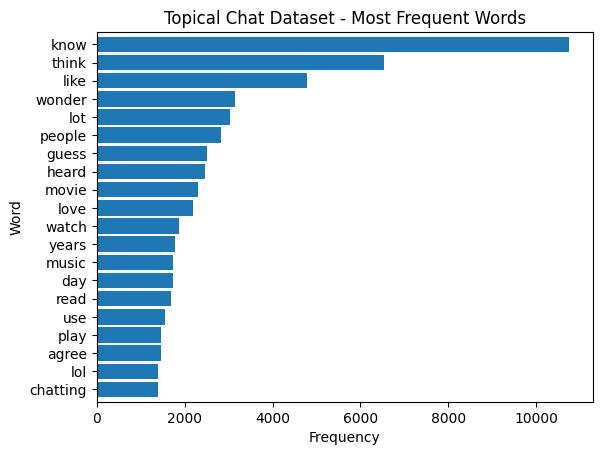

In [95]:
# Overall stats
ct_conv = dftc2.shape[0]
ct_exch = dftc2['msg_ct'].sum()
ct_sents = dftc2['ct_sents'].sum()
ct_words = dftc2['ct_words'].sum()
print('conversations:', ct_conv)
print('exchanges:', ct_exch)
print('avg exchanges per conversation:', ct_exch / ct_conv)
print('sentences:', ct_sents)
print('avg sentences per conversation:',  ct_sents/ ct_conv)
print('words:', ct_words)
print('avg words per conversation:', ct_words / ct_conv)

all_words = []
for doc in [words for words in dftc2['words'].values]:
    for words in doc:
        all_words.append(words)
word_freq = Counter(all_words)
topn_words_tc = word_freq.most_common(topn)

print('topn words:', topn_words_tc)
print()

# Freq dist
dff = pd.DataFrame(topn_words_tc)
dff.columns = ['word', 'freq']
dff.index=dff['word']
#display(dff)
ax = dff.plot(kind='barh', width=0.85, legend=False)
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Word', title='Topical Chat Dataset - Most Frequent Words')

# Stats
topstr = ', '.join([w[0] for w in topn_words_tc])
dftmp = pd.DataFrame({
    'Dataset': 'Topical Chat',
    'Conversations': [ct_conv],
    'Exchanges': [ct_exch],
    'Avg Exchanges Per Conv': [ct_exch / ct_conv], 
    'Sentences': [ct_sents],
    'Avg Sentences Per Conv': [ct_sents/ ct_conv],
    'Words': [ct_words],
    'Avg Words Per Conv': [ct_words / ct_conv],
    'Top Words': [topstr]
})
dfstats = pd.concat([dfstats, dftmp], ignore_index=True, axis=0)
display(dfstats)


### Ubuntu Dialogue dataset

This section loads, tokenises, and collects basic stats about the Ubuntu Dialogue dataset.


In [31]:
#############################################
# Ubuntu Dialogue dataset
#############################################

# Function to load the Ubuntu Dialogue dataset
def load_ubuntu(num_docs):
    """
    Purpose:             To load the Ubuntu Dialogue dataset into memory.
    Parameters:
        num_docs         The number of conversations to load.
    Returns:
        docs_txt         List of conversations in plain-text format.
        ct_msgs_corpus   Count of messages (conversations) in the corpus.
    """

    # Path
    path_to_docs = 'C:/Users/micha/Documents/698/corpora/ubuntu_dialogues/dialogs'
    
    # Init document list
    docs_txt = []

    # Iterate over directories
    ct_conv = 0
    ct_msgs_corpus = []
    ct_err = 0
    for d in os.listdir(path_to_docs):

        # Iterate over files in directory
        print('dir', d)
        for f in os.listdir(path_to_docs + '/' + d):

            # Verify it's a file
            fn = path_to_docs + '/' + d + '/' + f
            if os.path.isfile(fn):

                # Init 
                doc_msgs = ''
        
                # Read the file
                with open(fn, 'r', encoding='latin-1') as fh:

                    # Reach each line; each line is a separate message from a single user
                    ct_conv += 1
                    ct_msgs = 0
                    while True:

                        # Read line
                        l = fh.readline()
                        if not l:
                            break

                        # Split to an array; each line will be in this format: timestamp[tab]sender[tab]receiver[tab]message
                        # e.g.: 2005-05-26T16:54:00.000Z[tab]lifeless[tab]we2by[tab]calm down please
                        tmp = l.strip().split('\t')
                        if len(tmp) == 4:

                            # Concatenate to all the messages in the conversation
                            doc_msgs += tmp[3] + ' '
                            ct_msgs += 1
                            
                        else:
                            # Not the right number of fields in this message
                            ct_err += 1
                            
                # Append count to the overall corpus counts (for stats purposes)
                ct_msgs_corpus.append(ct_msgs)

                # Append to docs list
                docs_txt.append(doc_msgs)

            # Break early
            if ct_conv % 1000 == 0: print(ct_conv)
            if num_docs > 0 and ct_conv >= num_docs:
                break
                
        # Break early
        if ct_conv % 1000 == 0: print(ct_conv)
        if num_docs > 0 and ct_conv >= num_docs:
            break

    # Doc summary
    print(f'Number of docs (conversations): {ct_conv}')
    print(f'Number of errs: {ct_err}')
    
    # Return
    return docs_txt, ct_msgs_corpus


In [59]:
# Load Ubuntu Dialogue data set
ud_txt, ud_msg_ct = load_ubuntu(10000)
#print(ud_msg_ct)


dir 10
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
10000
Number of docs (conversations): 10000
Number of errs: 12


In [60]:
# Make dataframe
dfud = pd.DataFrame({'txt': ud_txt, 'msg_ct': ud_msg_ct, 'chat_ct': 1})
print(dfud.shape)

# Only take conversations with more than 5 exchanges
dfud = dfud[dfud['msg_ct'] > 5].reset_index()
print(dfud.shape)
#display(dfud)


(10000, 3)
(10000, 4)


In [61]:
# Iterate to tokenise
ct_words_corpus = []
ct_sents_corpus = []
topn_words_corpus = []
words_corpus_ud = []
topn = 20
for i, row in dfud.iterrows():
    if i % 100 == 0: print(i)
    ct_words, ct_sents, topn_words, words = do_tokenise(row['txt'], topn, ['NOUN', 'PROPN', 'VERB'])
    ct_words_corpus.append(ct_words)
    ct_sents_corpus.append(ct_sents)
    topn_words_corpus.append(topn_words)
    words_corpus_ud.append(words)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


In [62]:
# Show dataframe
dftmp = pd.DataFrame({'ct_words': ct_words_corpus, 'ct_sents': ct_sents_corpus, 'topn_words': topn_words_corpus, 'words': words_corpus_ud})
display(dftmp)
dfud2 = pd.concat([dfud, dftmp], axis=1, ignore_index=False)
display(dfud2)


,ct_words,ct_sents,topn_words,words
0,61,2,"[(command, 2), (sudo, 1), (echo, 1), (module, ...","[sudo, echo, module, usbcore, parameters, perm..."
1,108,9,"[(GLX, 2), (log, 2), (file, 2), (working, 2), ...","[GLX, work, X.Org, changed, log, file, says, s..."
2,206,6,"[(run, 3), (stored, 2), (created, 2), (user, 2...","[tell, stored, created, user, useradd, prompt,..."
3,240,16,"[(login, 5), (console, 4), (log, 4), (lightdm,...","[boot, mode, mean, rescue, mode, recovery, mod..."
4,74,3,"[(look, 4), (/etc, 3), (ifconfig, 2), (interfa...","[linux, system, look, settings, ifdown, ifconf..."
...,...,...,...,...
9995,129,4,"[(Dr_willis, 5), (/home, 2), (system, 2), (par...","[partitions, /home, like, /home, Dr_willis, as..."
9996,148,8,"[(server, 4), (boot, 3), (windows, 3), (ubuntu...","[boot, ubuntu, server, risk, bios, jamming, wi..."
9997,156,7,"[(wine, 5), (program, 4), (running, 3), (looki...","[ppl, got, program, running, wine, notepad++, ..."
9998,127,2,"[(linux, 3), (alternative, 2), (mentioned, 2),...","[alternative, mIrc, linux, ubuntu, kind, sucks..."


,index,txt,msg_ct,chat_ct,ct_words,ct_sents,topn_words,words
0,0,hi sudo echo Y > /sys/module/usbcore/parameter...,10,1,61,2,"[(command, 2), (sudo, 1), (echo, 1), (module, ...","[sudo, echo, module, usbcore, parameters, perm..."
1,1,Hmm Why doesn't GLX work with X.Org (I just ch...,10,1,108,9,"[(GLX, 2), (log, 2), (file, 2), (working, 2), ...","[GLX, work, X.Org, changed, log, file, says, s..."
2,2,hi can someone tell me where shell prompt name...,10,1,206,6,"[(run, 3), (stored, 2), (created, 2), (user, 2...","[tell, stored, created, user, useradd, prompt,..."
3,3,How do I boot in safe mode with 12.04? you me...,10,1,240,16,"[(login, 5), (console, 4), (log, 4), (lightdm,...","[boot, mode, mean, rescue, mode, recovery, mod..."
4,4,"Hello, I have a minimal linux system: how can ...",10,1,74,3,"[(look, 4), (/etc, 3), (ifconfig, 2), (interfa...","[linux, system, look, settings, ifdown, ifconf..."
...,...,...,...,...,...,...,...,...
9995,9995,"I have 2 partitions, one as / and the other as...",10,1,129,4,"[(Dr_willis, 5), (/home, 2), (system, 2), (par...","[partitions, /home, like, /home, Dr_willis, as..."
9996,9996,hey can you dual boot ubuntu server? now will ...,10,1,148,8,"[(server, 4), (boot, 3), (windows, 3), (ubuntu...","[boot, ubuntu, server, risk, bios, jamming, wi..."
9997,9997,"hi ppl Q: I've got a program running in wine, ...",10,1,156,7,"[(wine, 5), (program, 4), (running, 3), (looki...","[ppl, got, program, running, wine, notepad++, ..."
9998,9998,Q: Whats the best alternative to mIrc or hydra...,10,1,127,2,"[(linux, 3), (alternative, 2), (mentioned, 2),...","[alternative, mIrc, linux, ubuntu, kind, sucks..."


conversations: 10000
exchanges: 99988
avg exchanges per conversation: 9.9988
sentences: 61606
avg sentences per conversation: 6.1606
words: 1281429
avg words per conversation: 128.1429
topn words: [('ubuntu', 5274), ('install', 4711), ('use', 4598), ('know', 3798), ('need', 3214), ('try', 3188), ('want', 3041), ('help', 2943), ('work', 2527), ('file', 2407), ('sudo', 2344), ('installed', 2196), ('windows', 2110), ('thanks', 2038), ('problem', 2029), ('think', 2022), ('Ubuntu', 2020), ('run', 2004), ('boot', 1858), ('way', 1763)]



,Dataset,Conversations,Exchanges,Avg Exchanges Per Conv,Sentences,Avg Sentences Per Conv,Words,Avg Words Per Conv,Top Words
0,Chitchat,2963,132554,44.736416,151156,51.014512,2610900,881.167735,"think, know, people, like, going, lot, want, l..."
1,Topical Chat,3000,65563,21.854333,118536,39.512000,1511902,503.967333,"know, think, like, wonder, lot, people, guess,..."
2,Ubuntu Dialogue,10000,99988,9.998800,61606,6.160600,1281429,128.142900,"ubuntu, install, use, know, need, try, want, h..."


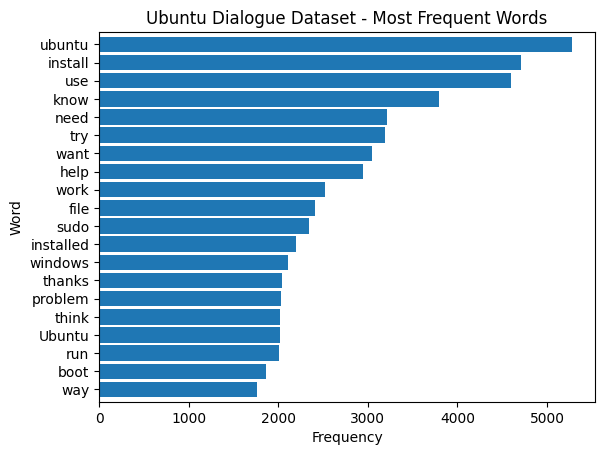

In [96]:
# Overall stats
ct_conv = dfud2.shape[0]
ct_exch = dfud2['msg_ct'].sum()
ct_sents = dfud2['ct_sents'].sum()
ct_words = dfud2['ct_words'].sum()
print('conversations:', ct_conv)
print('exchanges:', ct_exch)
print('avg exchanges per conversation:', ct_exch / ct_conv)
print('sentences:', ct_sents)
print('avg sentences per conversation:',  ct_sents/ ct_conv)
print('words:', ct_words)
print('avg words per conversation:', ct_words / ct_conv)

all_words = []
for doc in [words for words in dfud2['words'].values]:
    for words in doc:
        all_words.append(words)
word_freq = Counter(all_words)
topn_words_ud = word_freq.most_common(topn)

print('topn words:', topn_words_ud)
print()

# Freq dist
dff = pd.DataFrame(topn_words_ud)
dff.columns = ['word', 'freq']
dff.index=dff['word']
#display(dff)
ax = dff.plot(kind='barh', width=0.85, legend=False)
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Word', title='Ubuntu Dialogue Dataset - Most Frequent Words')

# Stats
topstr = ', '.join([w[0] for w in topn_words_ud])
dftmp = pd.DataFrame({
    'Dataset': 'Ubuntu Dialogue',
    'Conversations': [ct_conv],
    'Exchanges': [ct_exch],
    'Avg Exchanges Per Conv': [ct_exch / ct_conv], 
    'Sentences': [ct_sents],
    'Avg Sentences Per Conv': [ct_sents/ ct_conv],
    'Words': [ct_words],
    'Avg Words Per Conv': [ct_words / ct_conv],
    'Top Words': [topstr]
})
dfstats = pd.concat([dfstats, dftmp], ignore_index=True, axis=0)
display(dfstats)


### Enron Email dataset

This section loads, tokenises, and collects basic stats about the Enron Email dataset.


In [64]:
#############################################
# Enron Email dataset
#############################################

# Preload enron emails into dataframe
path_to_emails = 'C:/Users/micha/Documents/698/corpora/enron_emails/emails.csv'
dfee = pd.read_csv(path_to_emails)
dfee.drop(columns=['file'], inplace=True)
dfee['msg_ct'] = 1  # just assume each email = 1 message = 1 conversation
dfee['caht_ct'] = 1
dfee.rename(columns={'message': 'txt'}, inplace=True)

# Truncate
dfee = dfee[:5000]
display(dfee)


,txt,msg_ct,caht_ct
0,Message-ID: <18782981.1075855378110.JavaMail.e...,1,1
1,Message-ID: <15464986.1075855378456.JavaMail.e...,1,1
2,Message-ID: <24216240.1075855687451.JavaMail.e...,1,1
3,Message-ID: <13505866.1075863688222.JavaMail.e...,1,1
4,Message-ID: <30922949.1075863688243.JavaMail.e...,1,1
...,...,...,...
4995,Message-ID: <1618629.1075852693101.JavaMail.ev...,1,1
4996,Message-ID: <25218462.1075852693367.JavaMail.e...,1,1
4997,Message-ID: <20671206.1075852693390.JavaMail.e...,1,1
4998,Message-ID: <31930685.1075852693414.JavaMail.e...,1,1


In [65]:
# Iterate to tokenise
ct_words_corpus = []
ct_sents_corpus = []
topn_words_corpus = []
words_corpus_ee = []
topn = 20
for i, row in dfee.iterrows():
    if i % 100 == 0: print(i)
    ct_words, ct_sents, topn_words, words = do_tokenise(row['txt'], topn, ['NOUN', 'PROPN', 'VERB'])
    ct_words_corpus.append(ct_words)
    ct_sents_corpus.append(ct_sents)
    topn_words_corpus.append(topn_words)
    words_corpus_ee.append(words)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [66]:
# Show dataframe
dftmp = pd.DataFrame({'ct_words': ct_words_corpus, 'ct_sents': ct_sents_corpus, 'topn_words': topn_words_corpus, 'words': words_corpus_ee})
display(dftmp)
dfee2 = pd.concat([dfee, dftmp], axis=1, ignore_index=False)
display(dfee2)


,ct_words,ct_sents,topn_words,words
0,124,1,"[(Phillip, 2), (Allen, 2), (Tim, 2), (Belden, ...","[tim.belden@enron.com, Phillip, Allen, Tim, Be..."
1,284,11,"[(business, 4), (meetings, 4), (trip, 3), (Phi...","[Phillip, Allen, John, Lavorato, John, Lavorat..."
2,122,2,"[(test, 2), (Allen, 2), (Oct, 1), (leah.arsdal...","[Oct, leah.arsdall@enron.com, test, Phillip, A..."
3,152,3,"[(Phillip, 2), (Allen, 2), (Oct, 1), (randall....","[Oct, randall.gay@enron.com, Phillip, Allen, R..."
4,119,2,"[(Allen, 2), (Aug, 1), (greg.piper@enron.com, ...","[Aug, greg.piper@enron.com, Hello, Phillip, Al..."
...,...,...,...,...
4995,4439,91,"[(said, 31), (Company, 22), (company, 18), (po...","[Oct, m..schmidt@enron.com, Mentions, ANSI_X3...."
4996,1319,53,"[(deals, 8), (need, 6), (Michelle, 6), (trade,...","[Oct, office, issues, Abramo, Caroline, CABRAM..."
4997,142,2,"[(APB, 2), (Oct, 1), (Scott, 1), (Tanner, 1), ...","[Oct, APB, Scott, Tanner, scott.tanner@truequo..."
4998,675,5,"[(Arnold, 8), (BOARD, 7), (REDUCTION, 7), (ENE...","[Oct, jennifer.fraser@enron.com, BOARD, REDUCT..."


,txt,msg_ct,caht_ct,ct_words,ct_sents,topn_words,words
0,Message-ID: <18782981.1075855378110.JavaMail.e...,1,1,124,1,"[(Phillip, 2), (Allen, 2), (Tim, 2), (Belden, ...","[tim.belden@enron.com, Phillip, Allen, Tim, Be..."
1,Message-ID: <15464986.1075855378456.JavaMail.e...,1,1,284,11,"[(business, 4), (meetings, 4), (trip, 3), (Phi...","[Phillip, Allen, John, Lavorato, John, Lavorat..."
2,Message-ID: <24216240.1075855687451.JavaMail.e...,1,1,122,2,"[(test, 2), (Allen, 2), (Oct, 1), (leah.arsdal...","[Oct, leah.arsdall@enron.com, test, Phillip, A..."
3,Message-ID: <13505866.1075863688222.JavaMail.e...,1,1,152,3,"[(Phillip, 2), (Allen, 2), (Oct, 1), (randall....","[Oct, randall.gay@enron.com, Phillip, Allen, R..."
4,Message-ID: <30922949.1075863688243.JavaMail.e...,1,1,119,2,"[(Allen, 2), (Aug, 1), (greg.piper@enron.com, ...","[Aug, greg.piper@enron.com, Hello, Phillip, Al..."
...,...,...,...,...,...,...,...
4995,Message-ID: <1618629.1075852693101.JavaMail.ev...,1,1,4439,91,"[(said, 31), (Company, 22), (company, 18), (po...","[Oct, m..schmidt@enron.com, Mentions, ANSI_X3...."
4996,Message-ID: <25218462.1075852693367.JavaMail.e...,1,1,1319,53,"[(deals, 8), (need, 6), (Michelle, 6), (trade,...","[Oct, office, issues, Abramo, Caroline, CABRAM..."
4997,Message-ID: <20671206.1075852693390.JavaMail.e...,1,1,142,2,"[(APB, 2), (Oct, 1), (Scott, 1), (Tanner, 1), ...","[Oct, APB, Scott, Tanner, scott.tanner@truequo..."
4998,Message-ID: <31930685.1075852693414.JavaMail.e...,1,1,675,5,"[(Arnold, 8), (BOARD, 7), (REDUCTION, 7), (ENE...","[Oct, jennifer.fraser@enron.com, BOARD, REDUCT..."


conversations: 5000
exchanges: 5000
avg exchanges per conversation: 1.0
sentences: 47077
avg sentences per conversation: 9.4154
words: 1996747
avg words per conversation: 399.3494
topn words: [('Allen', 8171), ('Phillip', 7214), ('John', 5097), ('Arnold', 5090), ('documents', 1795), ('Jarnold.nsf', 1716), ('gas', 1617), ('know', 1318), ('need', 1257), ('\\Phillip_Allen_Dec2000\\Notes', 1233), ('Jeff', 1197), ('Gas', 1042), ('PALLEN', 1032), ('Jennifer', 1008), ('market', 1007), ('Thanks', 984), ('\\Phillip_Allen_June2001\\Notes', 980), ('information', 969), ('Mike', 948), ('said', 937)]



,Dataset,Conversations,Exchanges,Avg Exchanges Per Conv,Sentences,Avg Sentences Per Conv,Words,Avg Words Per Conv,Top Words
0,Chitchat,2963,132554,44.736416,151156,51.014512,2610900,881.167735,"think, know, people, like, going, lot, want, l..."
1,Topical Chat,3000,65563,21.854333,118536,39.512000,1511902,503.967333,"know, think, like, wonder, lot, people, guess,..."
2,Ubuntu Dialogue,10000,99988,9.998800,61606,6.160600,1281429,128.142900,"ubuntu, install, use, know, need, try, want, h..."
3,Enron Email,5000,5000,1.000000,47077,9.415400,1996747,399.349400,"Allen, Phillip, John, Arnold, documents, Jarno..."


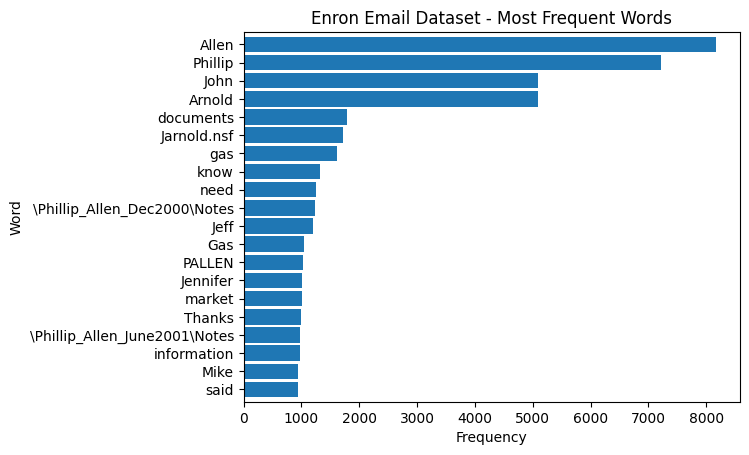

In [97]:
# Overall stats
ct_conv = dfee2.shape[0]
ct_exch = dfee2['msg_ct'].sum()
ct_sents = dfee2['ct_sents'].sum()
ct_words = dfee2['ct_words'].sum()
print('conversations:', ct_conv)
print('exchanges:', ct_exch)
print('avg exchanges per conversation:', ct_exch / ct_conv)
print('sentences:', ct_sents)
print('avg sentences per conversation:',  ct_sents/ ct_conv)
print('words:', ct_words)
print('avg words per conversation:', ct_words / ct_conv)

topn = 20
all_words = []
for doc in [words for words in dfee2['words'].values]:
    for words in doc:
        all_words.append(words)
word_freq = Counter(all_words)
topn_words_ee = word_freq.most_common(topn)

print('topn words:', topn_words_ee)
print()

# Freq dist
dff = pd.DataFrame(topn_words_ee)
dff.columns = ['word', 'freq']
dff.index=dff['word']
#display(dff)
ax = dff.plot(kind='barh', width=0.85, legend=False)
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Word', title='Enron Email Dataset - Most Frequent Words')

# Stats
topstr = ', '.join([w[0] for w in topn_words_ee])
dftmp = pd.DataFrame({
    'Dataset': 'Enron Email',
    'Conversations': [ct_conv],
    'Exchanges': [ct_exch],
    'Avg Exchanges Per Conv': [ct_exch / ct_conv], 
    'Sentences': [ct_sents],
    'Avg Sentences Per Conv': [ct_sents/ ct_conv],
    'Words': [ct_words],
    'Avg Words Per Conv': [ct_words / ct_conv],
    'Top Words': [topstr]
})
dfstats = pd.concat([dfstats, dftmp], ignore_index=True, axis=0)
display(dfstats)


### Dataset summary

This section creates a dataframe to summarise the dataset stats.


In [68]:
# Generate table of stats
dfstats2 = dfstats.copy()
dfstats2.index=dfstats2['Dataset']
dfstats2.drop(columns=['Dataset'], inplace=True)
dfstats2.rename(columns={'Avg Exchanges Per Conv': 'Avg Exch/Conv', 'Avg Sentences Per Conv': 'Avg Sent/Conv', 'Avg Words Per Conv': 'Avg Words/Conv'}, inplace=True)
display(dfstats2.iloc[:, :7])


,Conversations,Exchanges,Avg Exch/Conv,Sentences,Avg Sent/Conv,Words,Avg Words/Conv
Dataset,,,,,,,
Chitchat,2963,132554,44.736416,151156,51.014512,2610900,881.167735
Topical Chat,3000,65563,21.854333,118536,39.512000,1511902,503.967333
Ubuntu Dialogue,10000,99988,9.998800,61606,6.160600,1281429,128.142900
Enron Email,5000,5000,1.000000,47077,9.415400,1996747,399.349400


In [69]:
# Print stats
print(dfstats2['Conversations'].sum())
print(dfstats2['Exchanges'].sum())
print(dfstats2['Sentences'].sum())
print(dfstats2['Words'].sum())


20963
303105
378375
7400978


### Keyword in context

This section illustrates an example of keyword in context.


In [70]:
# Keyword-in-context for enron email, one example
x = dfee.loc[dfee['txt'].str.contains('HOU'), 'txt']
print(x.shape)
s = ' '.join(x)
kk = kwic.keyword_in_context(s, 'HOU', ignore_case=False, window_width=50)
ct = 0
for k in kk:
    ct += 1
    print(f'{k[0].replace('\n', ' ')}  {k[1]}  {k[2].replace('\n', ' ')}')
    if ct > 50: break


(1685,)
-------------------- Forwarded by Phillip K Allen/  HOU  /ECT on 10/16/2000  01:42 PM ---------------------
-------------------- Forwarded by Phillip K Allen/  HOU  /ECT on 10/09/2000  02:16 PM ---------------------
urchfield 10/06/2000 06:59 AM To: Phillip K Allen/  HOU  /ECT@ECT cc: Beth Perlman/HOU/ECT@ECT  Subject: Co
 To: Phillip K Allen/HOU/ECT@ECT cc: Beth Perlman/  HOU  /ECT@ECT  Subject: Consolidated positions: Issues 
----------------- Forwarded by Richard Burchfield/  HOU  /ECT on 10/06/2000  08:34 AM ---------------------
verude 10/05/2000 06:03 PM To: Richard Burchfield/  HOU  /ECT@ECT cc: Peggy Alix/HOU/ECT@ECT, Russ Severson
To: Richard Burchfield/HOU/ECT@ECT cc: Peggy Alix/  HOU  /ECT@ECT, Russ Severson/HOU/ECT@ECT, Scott  Mills/
ECT@ECT cc: Peggy Alix/HOU/ECT@ECT, Russ Severson/  HOU  /ECT@ECT, Scott  Mills/HOU/ECT@ECT, Kenny Ha/HOU/E
/ECT@ECT, Russ Severson/HOU/ECT@ECT, Scott  Mills/  HOU  /ECT@ECT, Kenny Ha/HOU/ECT@ECT  Subject: Consolida
n/HOU/ECT@ECT, Scott

### Human-generated keywords

This section shows snippets of the dataset I hand-labeled for topic relevance.


In [73]:
# Read file containing human-generated keyword lists
dfkw = pd.read_excel('C:/Users/micha/Box Sync/cuny/698-Capstone/keywords.xlsx')
display(dfkw)


,Dataset,Doc_id,Snippet,Topic_words,Human_topic,Relevant
0,chitchat,1035.0,i never turn mine off anyways updates would ju...,"browser,college,major,BYU,student,media,marketing",traveling,1
1,chitchat,1334.0,Hello fellow human! As a human with skin and h...,"smell,friends,hangout,rpg,game,play,munchkin,b...",NaN,1
2,chitchat,808.0,Hello! Hahaha hey again! :) I was having a con...,"pizza,restaurant,topping,pepper,santa cruz,lag...",NaN,1
3,chitchat,985.0,"Hello? hey! Hello! Sorry, this is the first ti...","book,bank,florence,machine,panic,disco,music,j...",NaN,1
4,chitchat,791.0,Oh for sure :p oh my finally a person! I anni ...,"south korea,metal,listen,music,rap,hiphop,rb,c...",NaN,1
...,...,...,...,...,...,...
163,enron email,4128.0,NaN,"payout,investment,builders,profit,repaid,split...",NaN,0
164,enron email,205.0,NaN,"notes,outlook,migration,survey,fill,computer,p...",NaN,0
165,enron email,205.0,NaN,"overdue,access,request,mat,smith,pending,approval",NaN,0
166,enron email,3418.0,NaN,"extension, document, engineer, architect, acco...",NaN,0


In [194]:
# Print conversations referenced in the human-generated keyword dataframe
for i, row in dfkw.iterrows():

    # Choose dataset
    if row['Dataset'] == 'chitchat':
        dftmp = dfcc
    elif row['Dataset'] == 'topical chat':
        dftmp = dftc
    elif row['Dataset'] == 'ubuntu dialogue':
        dftmp = dfud
    elif row['Dataset'] == 'enron email':
        dftmp = dfee

    # Get document
    docrow = dftmp.loc[dftmp.index == row['Doc_id'], 'txt']
    if len(docrow) > 0:
        doc = dftmp.loc[dftmp.index == row['Doc_id'], 'txt'].values[0]
        #print(row['Snippet'])
        #print()
        #print(doc)
        if not pd.isna(row['Snippet']) and row['Snippet'] not in doc:
            print(f'WARNING, snippet not in doc! dataset={row['Dataset']}, id={row['Doc_id']}')


WARNING, snippet not in doc! dataset=topical chat, id=1950.0
WARNING, snippet not in doc! dataset=topical chat, id=2276.0
WARNING, snippet not in doc! dataset=enron email, id=808.0
WARNING, snippet not in doc! dataset=enron email, id=985.0
WARNING, snippet not in doc! dataset=enron email, id=1950.0
WARNING, snippet not in doc! dataset=enron email, id=974.0
WARNING, snippet not in doc! dataset=enron email, id=595.0
WARNING, snippet not in doc! dataset=enron email, id=995.0


### TSNE graphs

This section generates TSNE (t-distributed stochastic neighbor embedding) graphs to illustrate clusters of similar words.


In [131]:
# TSNE (t-distributed stochastic neighbor embedding) graphs

# Create word2vec word embeddings
w2v = {}
for ds in dslist:
    words_corpus = eval('words_corpus_' + ds)
    print(f"creating word embeddings for {ds}")
    w2v[ds] = word2vec.Word2Vec(words_corpus, vector_size=300, window=30, min_count=1, sample=1e-3, epochs=5)


creating word embeddings for cc
creating word embeddings for tc
creating word embeddings for ud
creating word embeddings for ee


In [132]:
# Get similar words
num_words = 5  # number of words to return in search for similar words
sim_words = {}
for ds in dslist:
    sim_words[ds] = {}
    for topn_word in eval('topn_words_' + ds)[:10]:
        for e in w2v[ds].wv.most_similar([topn_word], topn=num_words):
            if topn_word[0] not in sim_words[ds].keys():
                sim_words[ds][topn_word[0]] = []
            sim_words[ds][topn_word[0]].append(e[0])
print(sim_words)


{'cc': {'think': ['point', 'mean', 'change', 'relationships', 'granted'], 'know': ['ask', 'Buuuut', 'relationship', 'knows', 'anonymity'], 'people': ['People', 'relationships', 'assures', 'temptations', 'connections'], 'like': ['enjoy', 'Alternative', 'genres', 'love', 'PCT'], 'going': ['goodluck', 'Congrats', 'heading', 'going?4', 'plans'], 'lot': ['Arn', 'anchored', 'strays', 'betterment', 'focusing'], 'want': ['wants', 'opportunities', 'plan', 'motherhood', 'pediatricians'], 'love': ['Bbq', 'like', 'resturaunts', 'Adele', 'beacuase'], 'got': ['ended', 'O.O', 'Whaaat', 'DANG', 'noooooooooooooooooooooooooooooooo'], 'Haha': ['Hahaha', 'haha', 'lol', 'Prom', 'brimming']}, 'tc': {'know': ['wonder', 'Speaking', 'knew', 'guess', 'heard'], 'think': ['agree', 'blunder', 'mean', 'chna', 'amounts'], 'like': ['love', 'Museums', 'Wife', 'drum', 'Gallery'], 'wonder': ['guess', 'eiffel', 'violated', 'impersonating', 'France'], 'lot': ['spend', 'rent', 'riches', 'grown', 'DVD'], 'people': ['filings

In [147]:
# Generate word2vec embeddings for TSNE graphs
wordlist = {}
w2v_vecs = {}
for ds in dslist:

    # Create flattened word list for TSNE graphs
    wordlist[ds] = []
    for k in sim_words[ds].keys():
        sim_words[ds][k].append(k)  # append the key word to the list of words
        wordlist[ds].extend(sim_words[ds][k])
    wordlist[ds] = list(set(wordlist[ds]))
    print(ds)
    print(wordlist[ds])
    print()

    # Remove outlier words that make the graph hard to read
    if ds == 'ee':
        wordlist[ds].remove('beginning')
        wordlist[ds].remove('.0475')

    # Get word vectors for the wordlist
    w2v_vecs[ds] = w2v[ds].wv[wordlist[ds]]
    

cc
['strays', 'like', 'Bbq', 'O.O', 'Hahaha', 'mean', 'motherhood', 'relationship', 'brimming', 'beacuase', 'DANG', 'wants', 'genres', 'People', 'Whaaat', 'knows', 'PCT', 'plan', 'ended', 'noooooooooooooooooooooooooooooooo', 'going', 'love', 'focusing', 'lot', 'Adele', 'anonymity', 'want', 'got', 'assures', 'connections', 'Prom', 'think', 'people', 'goodluck', 'know', 'point', 'plans', 'Alternative', 'heading', 'change', 'pediatricians', 'ask', 'temptations', 'haha', 'anchored', 'Haha', 'relationships', 'Congrats', 'going?4', 'Arn', 'lol', 'Buuuut', 'betterment', 'enjoy', 'resturaunts', 'opportunities', 'granted']

tc
['Phineas', 'Museums', 'like', 'Ferb', 'agree', 'mean', 'yorke', 'directed', 'heard', 'incredibles', 'grown', 'blunder', 'wants', 'fwith', 'rent', 'mood', 'love', 'film', 'filings', 'lot', 'Gurls', 'abide', 'Wife', 'constitution', 'West', 'knew', 'France', 'spend', 'eiffel', 'think', 'riches', 'people', 'know', 'Gallery', 'DVD', 'violated', 'Facebook', 'chna', 'trying', '

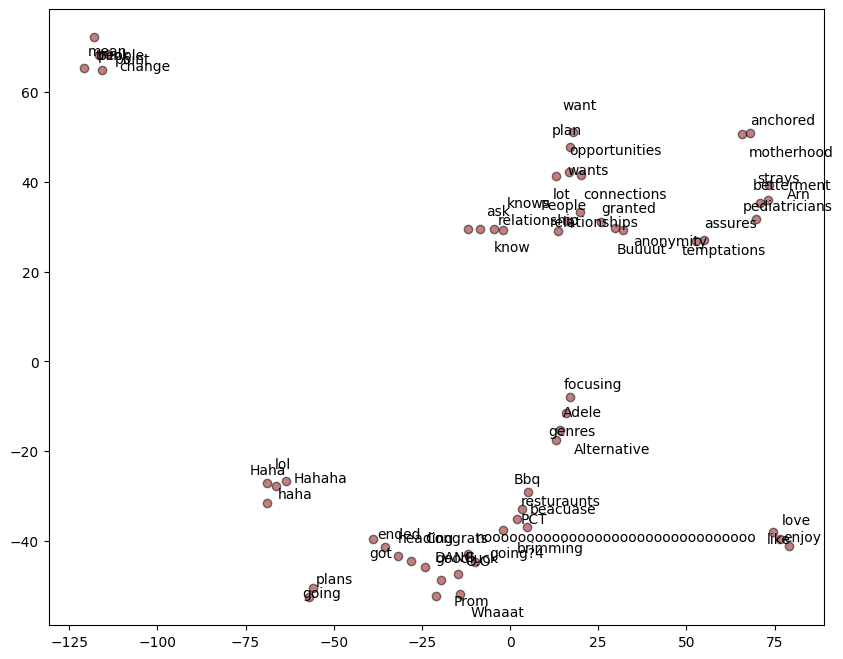

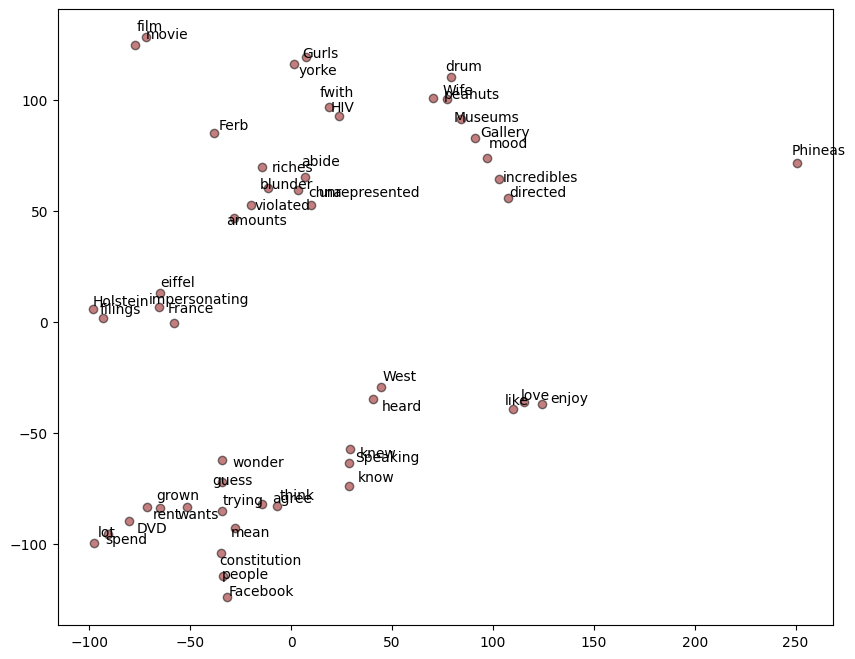

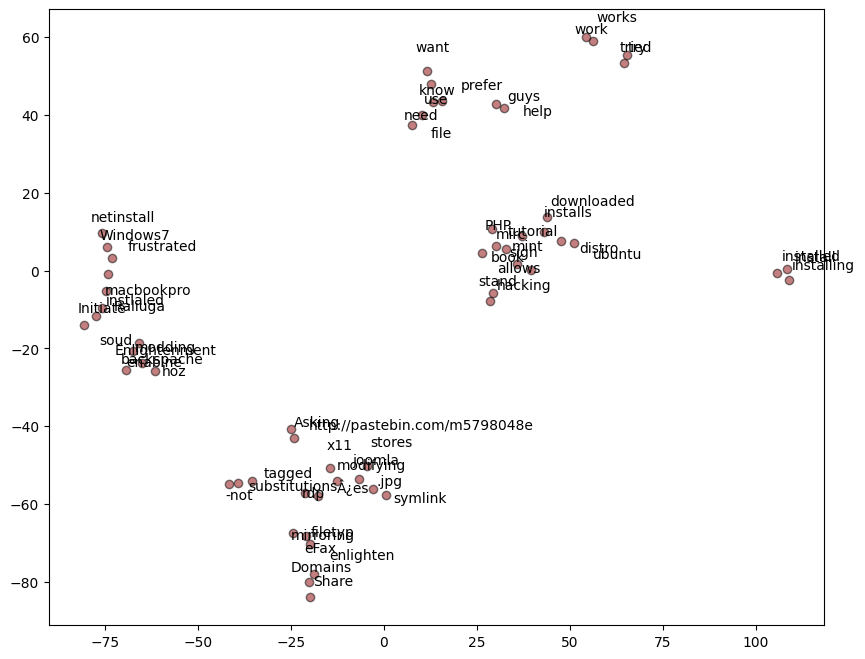

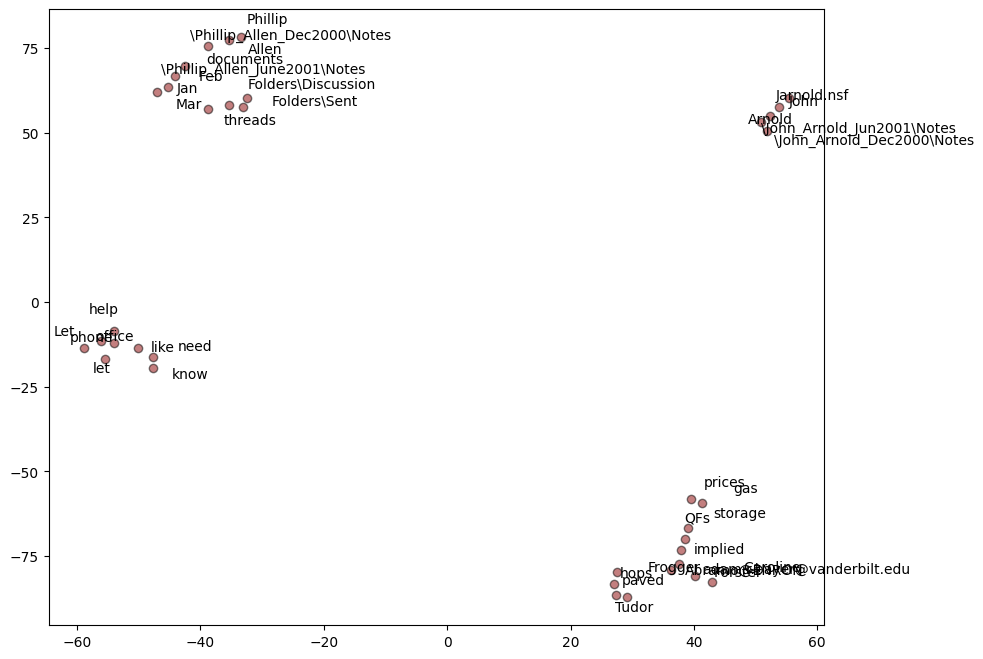

In [192]:
# Set random seeds per dataset that make the graphs more readable
seeds = {'cc': 1, 'tc': 1, 'ud': 1, 'ee': 12}

# TSNE graphs
for ds in dslist:
    tsne = TSNE(n_components=2, random_state=77, n_iter=10000, perplexity=2)
    np.set_printoptions(suppress=True)
    T = tsne.fit_transform(w2v_vecs[ds])
    labels = wordlist[ds]
    plt.figure(figsize=(10, 8))
    plt.scatter(T[:, 0], T[:, 1], c='#880000', edgecolors='#000000', alpha=0.5)
    #plt.title(f"t-SNE - {datasetmap[ds]}")
    random.seed(seeds[ds])
    for label, x, y in zip(labels, T[:, 0], T[:, 1]):
        x_offset = random.randint(-5,5)
        y_offset = random.randint(-5,5)
        plt.annotate(label, xy=(x + x_offset, y + y_offset), xytext=(0, 0), textcoords='offset points')
